### Automated anomaly detection using PyOD and Auto-Sklearn
This notebook incorporates anomaly detection algorithms from PyOD into Auto-Sklearn. The following steps are followed:
- Auto-Sklearn is extended to incorporate PyOD algorithms
- Anomaly detection dataset(s) are imported and pre-processed
- Dataset is passed to Auto-Sklearn automl object for automated modeling and prediction
- Results and stats are obtained and analyzed

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import arff
import sklearn.metrics
from sklearn.model_selection import train_test_split, PredefinedSplit
from autosklearn.pipeline.components.classification import add_classifier
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc, average_precision

In [2]:
def import_dataset(filepath):
    """ Function that reads the KDDCup99 dataset and returns a dataframe.

    Args:
        filename (str): The name of the file

    Returns:
        (df): The dataframe with the data contents
    """

    # If file does not exist
    if not os.path.exists(filepath):
        raise FileNotFoundError("filepath %s does not exist" % filepath)

    # Load file to a df
    data = arff.loadarff(filepath)
    df = pd.DataFrame(data[0])
    df.outlier = df.outlier.str.decode("utf-8")
    df['outlier'] = df['outlier'].map({'yes':1,'no':0}) 
    if 'id' in df:
        del df['id']

    return df

In [3]:
# Import DataFrame
N = 2000
df = import_dataset('data/Annthyroid_withoutdupl_norm_02_v01.arff')
if(len(df) > N):
    df = df.sample(n=N)
# Extract X, y
X  = df.iloc[:, :-1]
y = df['outlier']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print(X_train.shape)
print(X_test.shape)

(1600, 21)
(400, 21)


In [4]:
# Import Auto-Sklearn implemented PyOD classifiers
from src.pyod_models.abod import ABODClassifier # probabilistic
from src.pyod_models.cblof import CBLOFClassifier # proximity-based
from src.pyod_models.cof import COFClassifier # proximity-based
from src.pyod_models.copod import COPODClassifier # probabilistic
from src.pyod_models.ecod import ECODClassifier # probabilistic
from src.pyod_models.hbos import HBOSClassifier # proximity-based
from src.pyod_models.iforest import IForestClassifier # outlier ensembles
from src.pyod_models.knn import KNNClassifier # proximity-based
from src.pyod_models.lmdd import LMDDClassifier # linear model
from src.pyod_models.loci import LOCIClassifier # proximity-based
from src.pyod_models.lof import LOFClassifier # proximity-based
from src.pyod_models.mad import MADClassifier # probabilistic
from src.pyod_models.mcd import MCDClassifier # linear model
from src.pyod_models.ocsvm import OCSVMClassifier # linear model
from src.pyod_models.pca import PCAClassifier # linear model
from src.pyod_models.rod import RODClassifier # proximity-based
from src.pyod_models.sod import SODClassifier # proximity-based
from src.pyod_models.sos import SOSClassifier # probabilistic
# Add algorithms to the pipeline components of Auto-Sklearn
add_classifier(ABODClassifier)
add_classifier(CBLOFClassifier)
add_classifier(COFClassifier)
add_classifier(COPODClassifier)
add_classifier(ECODClassifier)
add_classifier(HBOSClassifier)
add_classifier(IForestClassifier)
add_classifier(KNNClassifier)
add_classifier(LMDDClassifier)
add_classifier(LOCIClassifier)
add_classifier(LOFClassifier)
add_classifier(MADClassifier)
add_classifier(MCDClassifier)
add_classifier(OCSVMClassifier)
add_classifier(PCAClassifier)
add_classifier(RODClassifier)
add_classifier(SODClassifier)
add_classifier(SOSClassifier)

In [7]:
# Pre-defined split indices for train and validation
selected_indices = []
sacrificed_outliers = 0 # count of outliers sampled for the training set
for v in y_train:
    if v==1: # outlier
        if np.random.rand()>0.05:
            selected_indices.append(1) # validation
        else:
            selected_indices.append(0) # training
            sacrificed_outliers += 1 # will not be used for evaluation
    else:
        if np.random.rand()>0.9:
            selected_indices.append(1) # validation
        else:
            selected_indices.append(0) # training
# prints
print('Number of outliers:', sum(y_train))
print('Number of sacrificed outliers:', sacrificed_outliers)
print('Number of validation samples:', sum(selected_indices))
print('Number of training samples:', len(y_train) - sum(selected_indices))

Number of outliers: 30
Number of sacrificed outliers: 1
Number of validation samples: 189
Number of training samples: 1411


In [8]:
# Build and fit a classifier
resampling_strategy = PredefinedSplit(test_fold=selected_indices)
automl = AutoSklearnClassifier(
    include = {
      'classifier': [
          'ABODClassifier',
          'CBLOFClassifier',
          #'COFClassifier',
          'COPODClassifier',
          'ECODClassifier',
          'HBOSClassifier',
          'IForestClassifier',
          'KNNClassifier',
          'LMDDClassifier',
          'LOCIClassifier',
          'LOFClassifier',
          #'MADClassifier', # only for univariate data
          'MCDClassifier',
          'OCSVMClassifier',
          'PCAClassifier',
          'RODClassifier',
          #'SODClassifier',
          'SOSClassifier'
      ],
      'feature_preprocessor': ["no_preprocessing"],
    },
    exclude = None,
    metric = roc_auc,
    scoring_functions = [roc_auc, average_precision],
    time_left_for_this_task = 60,
    per_run_time_limit = 10,
    ensemble_size = 1,
    initial_configurations_via_metalearning = 0,
    delete_tmp_folder_after_terminate = False,
    resampling_strategy = resampling_strategy,
)
# Fit
automl.fit(X_train, y_train, X_test, y_test, dataset_name='Annthyroid')

AutoSklearnClassifier(delete_tmp_folder_after_terminate=False, ensemble_size=1,
                      include={'classifier': ['ABODClassifier',
                                              'CBLOFClassifier',
                                              'COPODClassifier',
                                              'ECODClassifier',
                                              'HBOSClassifier',
                                              'IForestClassifier',
                                              'KNNClassifier', 'LMDDClassifier',
                                              'LOCIClassifier', 'LOFClassifier',
                                              'MCDClassifier',
                                              'OCSVMClassifier',
                                              'PCAClassifier', 'RODClassifier',
                                              'SOSClassifier'],
                               'feature_preprocessor': ['no_preprocessing']},
                   

In [9]:
# auto-sklearn execution details
print(automl.sprint_statistics())
# Top ranked model
print(automl.leaderboard(top_k=10))
# Top ranked model configuration
print()
print(automl.show_models())

auto-sklearn results:
  Dataset name: Annthyroid
  Metric: roc_auc
  Best validation score: 0.418934
  Number of target algorithm runs: 8
  Number of successful target algorithm runs: 7
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0

          rank  ensemble_weight            type      cost  duration
model_id                                                           
2            1              1.0  ABODClassifier  0.748985   6.94044

{2: {'model_id': 2, 'rank': 1, 'cost': 0.7489850991226461, 'ensemble_weight': 1.0, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7ff4fa3a1f70>, 'balancing': Balancing(random_state=1), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7ff4ea58cfa0>, 'classifier': <autosklearn.pipeline.components.classificati

In [10]:
# Refit due to PredefinedSplit
automl.refit(X_train, y_train)
# Evaluate on test set
y_pred = automl.predict_proba(X_test)
# score
score = roc_auc(y_test,y_pred[:,1])
print("ROC AUC score on test set:", score)

ROC AUC score on test set: 0.8495092693565977


In [13]:
# Get metric results function definition
def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    cols = ['rank_test_scores', 'status', 'param_classifier:__choice__', 'mean_test_score', 'mean_fit_time']
    cols.extend([key for key in cv_results.keys() if key.startswith('metric_')]) # if there are additional metrics
    return results[cols].sort_values(['rank_test_scores'])

# Call the function
print(get_metric_result(automl.cv_results_).to_string(index=False))

 rank_test_scores  status param_classifier:__choice__  mean_test_score  mean_fit_time  metric_roc_auc  metric_average_precision
                1 Success              ECODClassifier         0.418934       2.618977        0.418934                  0.054557
                2 Success               KNNClassifier         0.391217       3.272346        0.391217                  0.032272
                3 Success           IForestClassifier         0.282947       4.358127        0.282947                  0.049599
                4 Success              ABODClassifier         0.251015       6.940440        0.251015                  0.058224
                5 Success              HBOSClassifier         0.203849       5.329703        0.203849                  0.080602
                6 Success               LOFClassifier         0.107975       3.036151        0.107975                  0.030317
                7 Success               KNNClassifier         0.082820       4.275295        0.082820   

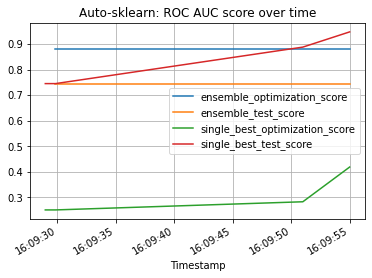

In [14]:
# Plot training performance over time
automl.performance_over_time_.plot(
   x='Timestamp',
   kind='line',
   legend=True,
   title='Auto-sklearn: ROC AUC score over time',
   grid=True,
)
plt.show()